In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import kruskal

%matplotlib inline

In [15]:
mplego.style.use_latex_style()

In [16]:
exp = "12"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [23]:
data = pd.read_feather(data_path)

In [17]:
group1 = "black"
group1_label = "Black"
group2 = "white"
group2_label = "White"

In [18]:
group1_target_results_path = os.path.join(results_path, f"exp{exp}_scores_{group1}.2.txt")
group2_target_results_path = os.path.join(results_path, f"exp{exp}_scores_{group2}.2.txt")

In [20]:
# Get severities for group1-targeting comments
group1_target_results = pd.read_csv(group1_target_results_path, delimiter='\t', skiprows=1)
group1_target_annotators = group1_target_results['Judges']
group1_target_severity = group1_target_results['Measure']
# Get severities for group2-targeting comments
group2_target_results = pd.read_csv(group2_target_results_path, delimiter='\t', skiprows=1)
group2_target_annotators = group2_target_results['Judges']
group2_target_severity = group2_target_results['Measure']

In [21]:
# Get annotators that looked at both group-targeting comments
common_annotators = group1_target_annotators[group1_target_annotators.isin(group2_target_annotators)].values
group1_target_common = group1_target_results[group1_target_annotators.isin(common_annotators)]
group2_target_common = group2_target_results[group2_target_annotators.isin(common_annotators)]
print(f'Common annotators: {common_annotators.size}')

Common annotators: 4276


In [31]:
group1_annotators = data[data[f'annotator_race_{group1}'] & ~data[f'annotator_race_{group2}']]['labeler_id'].values
group2_annotators = data[data[f'annotator_race_{group2}'] & ~data[f'annotator_race_{group1}']]['labeler_id'].values

In [32]:
# Group 1, targeting Group 1
group1_annotator_group1_target_sev = group1_target_common[group1_target_common['Judges'].isin(group1_annotators)]['Measure'].values
# Group 2, targeting Group 2
group1_annotator_group2_target_sev = group2_target_common[group2_target_common['Judges'].isin(group1_annotators)]['Measure'].values
group1_annotator_diffs = group1_annotator_group1_target_sev - group1_annotator_group2_target_sev
# Group 2, targeting Group 1
group2_annotator_group1_target_sev = group1_target_common[group1_target_common['Judges'].isin(group2_annotators)]['Measure'].values
# Group 2, targeting Group2
group2_annotator_group2_target_sev = group2_target_common[group2_target_common['Judges'].isin(group2_annotators)]['Measure'].values
group2_annotator_diffs = group2_annotator_group1_target_sev - group2_annotator_group2_target_sev

In [45]:
axis_label_size = 18
axis_tick_label_size = 14

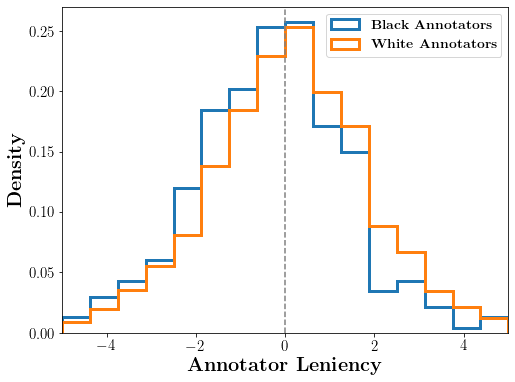

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bins = np.linspace(-5, 5, 17)

ax.hist(
    group1_annotator_diffs,
    bins=bins,
    histtype='step',
    linewidth=3,
    density=True,
    label=r'\textbf{' f'{group1_label}' r' Annotators}',
    color='C0')
ax.hist(
    group2_annotator_diffs,
    bins=bins,
    histtype='step',
    linewidth=3,
    density=True,
    label=r'\textbf{' f'{group2_label}' r' Annotators}',
    color='C1')
ax.set_xlim([-5, 5])
ax.axvline(0, linestyle='--', color='grey')
ax.tick_params(labelsize=15)
ax.set_xlabel(r'\textbf{Annotator Leniency}', fontsize=20)
ax.set_ylabel(r'\textbf{Density}', fontsize=20)
ax.legend(loc='best', prop={'size': 14})

In [27]:
group1_annotator_diffs

array([], dtype=float64)